<a href="https://colab.research.google.com/github/niels-overby/SRP2021/blob/main/SRP_noisereduction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#@title Setup

!git clone https://github.com/niels-overby/SRP2021.git

%pip install soundfile
%pip install resampy

import numpy as np
from scipy import signal

import matplotlib.pyplot as plt
import soundfile
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
import os

os.chdir("/content/SRP2021")

from audiotools import utils, processing, spectrum

# helper functions 
def interferringTone(x,fs,freq=2000,level_dB = 65):
    A = utils.from_dB(level_dB)
    xlen = np.max(x.shape)
    
    x_sin = A * np.sin(2*np.pi*freq * np.arange(xlen)/fs)
    
    return x_sin

def interferringNoise(x,fs,SNR = 10):
    x_noise = np.random.randn(*x.shape)
    x_noise, _ = utils.adjustSNR(x,x_noise,SNR)
    
    return x_noise


Cloning into 'SRP2021'...
remote: Enumerating objects: 153, done.
remote: Counting objects: 100% (153/153), done.
remote: Compressing objects: 100% (145/145), done.
remote: Total 153 (delta 56), reused 43 (delta 5), pack-reused 0
Receiving objects: 100% (153/153), 33.33 MiB | 12.42 MiB/s, done.
Resolving deltas: 100% (56/56), done.


# Del 3: Støjreduktion

I forrige øvelse så vi at støjfyldte signaler kan behandles i tids-frekvens domænet, og på den måde forbedre et ønsket signal. I bedste tilfælde kunne støjen fjernes fuldstændigt uden at det ønskede signal blev forringet. I virkelige scenarier er det dog sjældent at almindelige filtre kan benyttes til at fjerne støj. Dette vil vi undersøge i denne del af øvelsen.




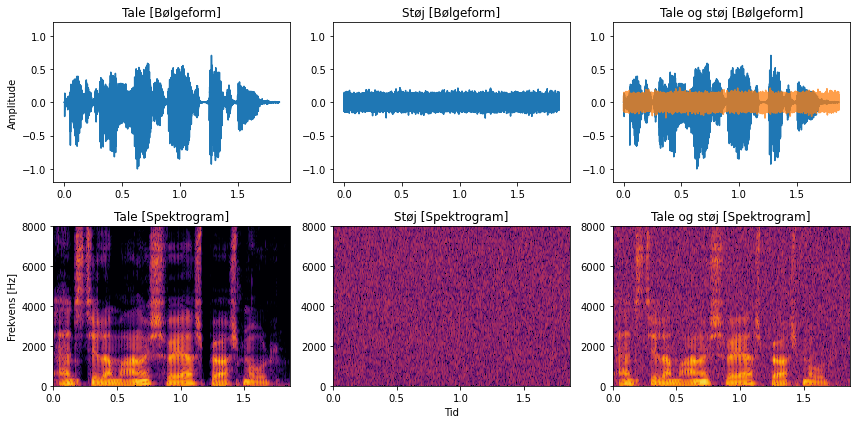

In [2]:
#@title Eksempel på støj i talesignal
audioDir = '/content/SRP2021/Audio/'
audioFiles = list(np.sort([f for f in os.listdir(audioDir) if f.endswith('.wav')]))


x, fs = utils.getAudio(audioDir+audioFiles[-1])
x = processing.normalize().transform(x)

x_noise = interferringNoise(x,fs,SNR=10)
x_m = x+x_noise

maxval = np.max(np.abs(x))

stft = spectrum.STFT(fs=fs,nperseg=512,nfft=2)
Xm = stft.transform(x_m)
X = stft.transform(x)
Xn = stft.transform(x_noise)

display(utils.play(x,fs))
display(utils.play(x_noise,fs))
display(utils.play(x_m,fs))


plt.figure(figsize=(12,6))

#plot tale (tid)

plt.subplot(231)
plt.title("Tale [Bølgeform]")
t = np.arange(len(x.T))/fs
plt.plot(t,x.T/maxval)
plt.ylim([-1.2,1.2])
plt.ylabel("Amplitude")

plt.subplot(234)
plt.title("Tale [Spektrogram]")
plt.pcolormesh(stft.t,stft.f,20*np.log10(np.abs(X[0])),vmin=0,vmax=75,cmap='inferno')
plt.ylim([0,8000])
plt.ylabel("Frekvens [Hz]")

#plot noise
plt.subplot(232)
plt.title("Støj [Bølgeform]")
plt.plot(t,x_noise.T/maxval)
plt.ylim([-1.2,1.2])

plt.subplot(235)
plt.title("Støj [Spektrogram]")
plt.pcolormesh(stft.t,stft.f,20*np.log10(np.abs(Xn[0])),vmin=0,vmax=75,cmap='inferno')
plt.ylim([0,8000])
plt.xlabel("Tid")

#plot mix
plt.subplot(233)
plt.title("Tale og støj [Bølgeform]")
plt.plot(t,x.T/maxval)
plt.plot(t,x_noise.T/maxval,alpha=0.75)
plt.ylim([-1.2,1.2])

plt.subplot(236)
plt.title("Tale og støj [Spektrogram]")
plt.pcolormesh(stft.t,stft.f,20*np.log10(np.abs(Xm[0])),vmin=0,vmax=75,cmap='inferno')
plt.ylim([0,8000])



plt.tight_layout()
plt.show()

* Beskriv hvordan signalet oven for lyder, og hvad forskellen er fra denne type støj og de eksempler vi arbejdede med i forrige øvelse.
* Hvordan kan støjen ses i spektrogrammet?

* Hvorfor kan lavpas- højpas- eller båndstop-filtre ikke bruges til at fjerne netop denne type støj?



# Måling af signal-støj forhold

Før vi starter med støjreduktion skal vi først forstå hvordan vi arbejder med støjfyldte signaler. Hvis et talesignal er mixet sammen med et støjsignal taler man ofte om signal-støjforhold som er en værdi der udtrykker hvor meget signalstyrken i forhold til støjstyrken.

I dette afsnit vil vi se på målemetoder til at bestemme signal styrken på digitale signaler, samt beregne signal støjforhold.


## Root mean square
Første del af at beregne signal-støjforholdet er ved at beregne signalstyrken af de signaler som et mix består af.

Signalstyrken kan måles i root-mean-square (forkortet: RMS). RMS beregnes ved at tage kvadratroden af middelværdien af signalet i anden potens. Matematisk kan det udtrykkes som i formlen nedenfor:

$x_{RMS} = \sqrt{\dfrac{1}{N}\sum_{n=0}^{N} x^2[n]}$,

Hvor $N$ er antallet af samples i signalet $x$. 

**Øvelse:**

Vi ønsker at beregne RMS værdien for et signal bestående af 8 elementer $x[n] = [0,1,0,-1,0,1,0,-1]$.

1. Opløft signalet i anden potens: $x^2[n] = \dots$

2. Beregn middelværdien for $x^2[n]$

3. Beregn kvadratroden af middelværdien

svar: 1.414

RMS kan fortolkes som den gennemsnitlige amplitude af et vilkårligt signal.

* Hvorfor opløfter vi signalet i anden potens?


## Beregning af signal-støj forhold

Signal-støj forholdet kan beregnes som forholdet mellem RMS værdien for signalet og støjen i anden potens.

$SNR = \big(\dfrac{A_s}{A_n}\big)^2$,

hvor $A_s$ er RMS amplituden for signalet, og $A_n$ er RMS amplituden for støjen. Da SNR udtrykkes i effekt og ikke i amplitude, opløftes forholdet i anden potens.

Typisk benyttes SNR$_{dB}$ som er decibel værdien af signal-støj forholdet. Decibel er en logaritmisk enhed til at beskrive forhold mellem signalniveauer. Fordelen ved at bruge en logaritmisk enhed er at den er tættere beslægtet på hvordan vi mennesker opfatter ændringer i lydniveauer.

$SNR_{dB} = 10 \log_{10} \big(\dfrac{A_s}{A_n}\big)^2 = 20 \log10\big(\dfrac{A_s}{A_n}\big)$

* Beregn signal-støj forholdet i dB hvis signalet og støjen har samme RMS amplitude
* Bereng signal-støj forholdet hvis signalet har den dobbelte RMS amplitude af støjen.
* Beregn igen signal-støj forholdet hvis støjen har den 3 dobbelte RMS amplitude af signalet.




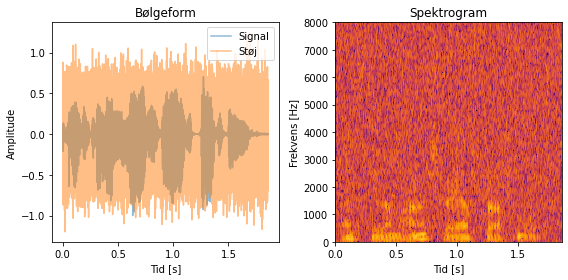

In [6]:
#@title SNR widget {run : "auto"}
#@markdown Prøv at ændre signal-støj forholdet ved brug af slideren.
#@markdown * Ved hvilken SNRdB værdi begynder det at blive svært at forstå taleren?

audioDir = '/content/SRP2021/Audio/'
audioFiles = list(np.sort([f for f in os.listdir(audioDir) if f.endswith('.wav')]))

x, fs = utils.getAudio(audioDir+audioFiles[-1])
x = processing.normalize().transform(x)
#x = x/np.max(np.abs(x))
SNRdB = -5 #@param {type:"slider",min:-24,max:24}
xnoise = interferringNoise(x,fs,SNR=SNRdB)

display(utils.play(x+xnoise,fs))

XN = stft.transform(xnoise+x)


t = np.arange(len(x.T))/fs

plt.figure(figsize=(8,4))
plt.subplot(121)
xmaxval = np.max(np.abs(x))
x = x/xmaxval
plt.plot(t,x.T,alpha=0.5,label='Signal')
plt.plot(t,xnoise.T/xmaxval,alpha=0.5,label='Støj')
plt.xlabel("Tid [s]")
plt.ylabel("Amplitude")
plt.title("Bølgeform")
plt.legend()

plt.subplot(122)
plt.pcolormesh(stft.t,stft.f,20*np.log10(np.abs(XN[0])),vmin=0,vmax=75,cmap='inferno')
plt.xlabel("Tid [s]")
plt.ylabel("Frekvens [Hz]")
plt.ylim([0,8000])
plt.colorbar()
plt.title("Spektrogram")


plt.tight_layout()
plt.show()




# Støjreduktion
Hvis man undersøger spektrogrammet ses det at lydniveauet af talesignalet er højere end lydniveauet af baggrundsstøjen. Denne information kan benyttes til at designe et filter der fjerner lave lyde og bevarer høje lyde. 



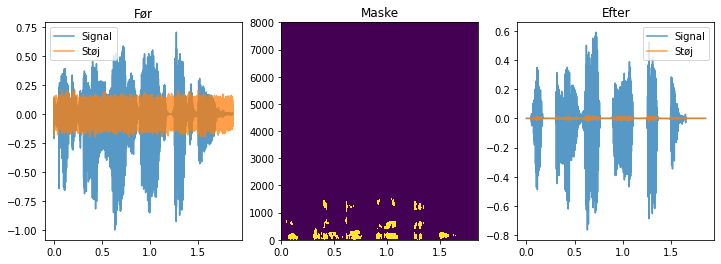

RMS Signal før: [0.15909506] 
RMS Støj før: [0.05031027] 
SNRdB før: [10.] 
RMS Signal efter: [0.11717789]
RMS Støj efter: [0.00295425]


In [10]:
#@title processing {run : "auto"}

audioDir = '/content/SRP2021/Audio/'
audioFiles = list(np.sort([f for f in os.listdir(audioDir) if f.endswith('.wav')]))

x, fs = utils.getAudio(audioDir+audioFiles[-1])
x = x/np.max(np.abs(x))
SNRdB = 10 #@param {type:"slider",min:-24,max:24}
xn = interferringNoise(x,fs,SNR=SNRdB)

xm = x + xn
t = np.arange(len(x.T))/fs

stft = spectrum.STFT(nperseg=512,fs=fs)

# Compute STFTs
X = stft.transform(x)
Xn = stft.transform(xn)
Xm = stft.transform(xm)

# Thresholding in log spectrogram, that way the linear slider makes more sense
XmLog = np.log(np.abs(Xm))
minVal = np.min(XmLog)
maxVal = np.max(XmLog)

threshold_percent = 97 #@param {type:"slider", min:0, max:100, step:1}
a = threshold_percent/100

thr = a * maxVal + (1-a) * minVal
mask = XmLog > thr

Y = mask * X
Yn = mask * Xn
Ym = mask * Xm

y = stft.transform(Y,inv=True)
yn = stft.transform(Yn,inv=True)
ym = stft.transform(Ym)

#plt.pcolormesh(stft.t,stft.f,mask[0])
plt.figure(figsize=(12,6))
plt.subplot(231)
plt.title("Før [Spektrogram]")
plt.pcolormesh(stft.t,stft.f,20*np.log10(np.abs(X[0])),vmin=-80,vmax=-15,cmap='inferno')
plt.ylim([0,8000])
plt.ylabel("Frekvens [Hz]")



plt.subplot(234)
plt.title("Før")
t = np.arange(len(x.T))/fs
plt.plot(t,x.T,label='Signal',alpha=0.75)
plt.plot(t,xn.T,label='Støj',alpha=0.75)



#plot noise
plt.subplot(232)
plt.pcolormesh(stft.t,stft.f,mask[0])
plt.ylim([0,8000])
plt.title("Maske")




#plot mix
plt.subplot(233)
plt.title("Efter [Spektrogram]")
plt.pcolormesh(stft.t,stft.f,20*np.log10(np.abs(Y[0]+1e-9)),vmin=-80,vmax=-15,cmap='inferno')
plt.ylim([0,8000])
plt.ylabel("Frekvens [Hz]")


plt.subplot(236)
t = np.arange(len(y.T))/fs
plt.plot(t,y.T,label='Signal',alpha=0.75)
plt.plot(t,yn.T,label='Støj',alpha=0.75)
plt.title("Efter")





display(utils.play(ym,fs))

print(f"RMS Signal før: {utils.rms(x)} ")
print(f"RMS Støj før: {utils.rms(xn)} ")
print(f"SNRdB før: {20*np.log10(utils.rms(x)/utils.rms(xn))} ")

print(f"RMS Signal efter: {utils.rms(y)}")
print(f"RMS Støj efter: {utils.rms(yn)}")

### Støjreduktion i højt input SNRdB

Start med at sætte SNRdB på 10, og threshold_percent på 0.

* Hvordan lyder det støjede talesignal? 

* Prøv nu at hæv thresholdet til et punkt hvor du ikke stort set ikke længere kan hører støjen. 

* Hvordan lyder talesignalet efter støjreduktion forskelligt i forhold til det oprindelige talesignal? (Lyt til det oprindelige signal øverst på denne side).

* Flyt nu threshold slideren op til 90%, hvordan lyder talesignalet nu? og hvilke typer af fonemer er bevaret?

* Tegn en graf for ændringen i SNR og talesignalsniveauet ved følgende threshold værdier [50,55,60,65,70,75,80,85,90,95,99]. Hint: skriv værdierne ind i Excel eller lignende. Hvor meget kan vi hæve signal-støj forholdet med hvis ændringen af talesignalet ikke må blive på mindre end -1dB?


### Støjreduktion i lavt input SNRdB

Flyt ny SNRdB ned på 0 dB og gentag forrige øvelse.

* Hvilke forskelle er der på den optimale løsning ved højt SNR og lavt SNR?





### Begrænsninger ved thresholding metoden

Ofte er vi ikke så heldige at støjsignalet er umoduleret hvid støj som før. I denne sidste del af øvelsen skal vi se om vi kan fjerne en samtidig taler. I denne øvelse er tale signalet sætningen "Han stiller mange svære spørgsmål", og støj signalet er sætnignen "De mørke pletter skyldes maling". 


* Prøv først at flytte på signalet ved uden støjreduktion (threshold < 30), kan du stadig hører hvad taleren siger?

* Forsøg nu at fjerne baggrundstøjen ved hjælp af thresholding metoden.

* Hvorfor virker thresholding metoden ikke lige så godt i denne type støj?

* Tegn evt. grafen igen for ændringen af SNR og ændringen i tale signalet, og undersøg hvor stor en ændring der kan opnås i SNR, før talesignalet blive forringet med mere end 1dB.

* Diskuter om der kunne være andre metoder til at fjerne støj på i høreapparater.

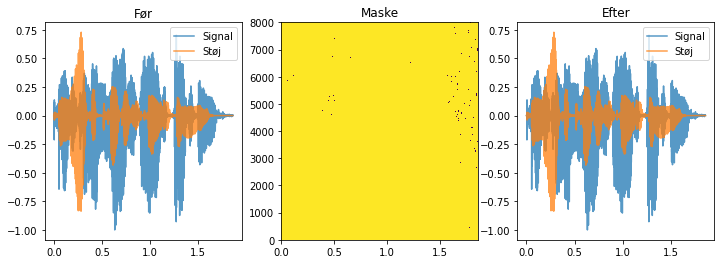

RMS Signal før: [0.15909506] 
RMS Støj før: [0.07973641] 
SNRdB før: [6.] 
RMS Signal efter: [0.15908924]
RMS Støj efter: [0.07973349]


In [ ]:
#@title processing {run : "auto"}


audioDir = '/content/SRP2021/Audio/'
audioFiles = list(np.sort([f for f in os.listdir(audioDir) if f.endswith('.wav')]))

interferringTalker ,_ = utils.getAudio(audioDir+audioFiles[-3])

x, fs = utils.getAudio(audioDir+audioFiles[-1])
x = x/np.max(np.abs(x))

x, interferringTalker = utils.sameLength(x,interferringTalker)

xn,_ = utils.adjustSNR(x,interferringTalker,6)

xm = x + xn
t = np.arange(len(x.T))/fs

stft = spectrum.STFT(nperseg=512,fs=fs)

# Compute STFTs
X = stft.transform(x)
Xn = stft.transform(xn)
Xm = stft.transform(xm)

# Thresholding in log spectrogram, that way the linear slider makes more sense
XmLog = np.log(np.abs(Xm))
minVal = np.min(XmLog)
maxVal = np.max(XmLog)

threshold_percent = 12 #@param {type:"slider", min:0, max:100, step:1}
a = threshold_percent/100

thr = a * maxVal + (1-a) * minVal
mask = XmLog > thr

Y = mask * X
Yn = mask * Xn
Ym = mask * Xm

y = stft.transform(Y,inv=True)
yn = stft.transform(Yn,inv=True)
ym = stft.transform(Ym)

#plt.pcolormesh(stft.t,stft.f,mask[0])

plt.figure(figsize=(12,4))

plt.subplot(131)
t = np.arange(len(x.T))/fs
plt.plot(t,x.T,label='Signal',alpha=0.75)
plt.plot(t,xn.T,label='Støj',alpha=0.75)
plt.title("Før")
plt.legend()

plt.subplot(132)
plt.pcolormesh(stft.t,stft.f,mask[0])
plt.ylim([0,8000])
plt.title("Maske")


plt.subplot(133)
t = np.arange(len(y.T))/fs
plt.plot(t,y.T,label='Signal',alpha=0.75)
plt.plot(t,yn.T,label='Støj',alpha=0.75)
plt.title("Efter")
plt.legend()
plt.show()

display(utils.play(ym,fs))

print(f"RMS Signal før: {utils.rms(x)} ")
print(f"RMS Støj før: {utils.rms(xn)} ")
print(f"SNRdB før: {20*np.log10(utils.rms(x)/utils.rms(xn))} ")

print(f"RMS Signal efter: {utils.rms(y)}")
print(f"RMS Støj efter: {utils.rms(yn)}")
